In [1]:
import copy
import numpy as np
import scipy.sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt

In [2]:
ga = 2       # CRRA utility with parameter gamma
alpha = 0.35 # Production function F = K^alpha * L^(1-alpha) 
delta = 0.1  # Capital depreciation
zmean = 1.0  # mean O-U process (in levels). This parameter has to be adjusted to ensure that the mean of z (truncated gaussian) is 1.
sig2 = (0.1)**2  # sigma^2 O-U
Corr = np.exp(-0.3)  # persistence -log(Corr)  O-U
rho = 0.05   # discount rate

K = 3.8       # initial aggregate capital. It is important to guess a value close to the solution for the algorithm to converge
relax = 0.99  # relaxation parameter 
J = 40        # number of z points 
zmin = 0.5    # Range z
zmax = 1.5
amin = -1     # borrowing constraint
amax = 30     # range a
I = 100       # number of a points 

#simulation parameters
maxit  = 100     # maximum number of iterations in the HJB loop
maxitK = 100     # maximum number of iterations in the K loop
crit = 10**(-6)  # criterion HJB loop
critK = 10**(-5) # criterion K loop
Delta = 1000     # delta in HJB algorithm

#ORNSTEIN-UHLENBECK IN LEVELS
the = -np.log(Corr)
Var = sig2/(2*the)


a = np.linspace(amin,amax,I).reshape((I,1))
da = (amax-amin)/(I-1)

z = np.linspace(zmin,zmax,J).reshape((J,1))
dz = (zmax-zmin)/(J-1)
dz2 = dz**2

aa = a * np.ones((I, J))
zz = np.ones((I, J)) * z.T

mu = the*(zmean - z).reshape((1,J))
s2 = sig2*np.ones((1,J))

Vaf = np.zeros((I,J))
Vab = np.zeros((I,J))
Vzf = np.zeros((I,J))
Vzb = np.zeros((I,J))
Vzz = np.zeros((I,J))
c = np.zeros((I,J))

chi =  (-np.minimum(mu,0)/dz + s2/(2*dz2)).reshape((J,1))
yy =  (np.minimum(mu,0)/dz - np.maximum(mu,0)/dz - s2/dz2).reshape((J,1))
zeta = (np.maximum(mu,0)/dz + s2/(2*dz2)).reshape((J,1))

In [3]:
# This will be the upperdiagonal of the B_switch  page 18 C
updiag = np.zeros((I,1))
for j in range(J):
    updiag = np.vstack((updiag, np.tile(zeta[j], (I,1))))

# This will be the center diagonal of the B_switch
centdiag = np.tile(chi[0]+yy[0],(I,1))
for j in range(1,J-1):
    centdiag = np.vstack((centdiag, np.tile(yy[j], (I,1))))
centdiag = np.vstack((centdiag, np.tile(yy[J-1]+zeta[J-1], (I,1))))

# This will be the lower diagonal of the B_switch
lowdiag = np.tile(chi[1], (I,1))
for j in range(2,J):
    lowdiag = np.vstack((lowdiag, np.tile(chi[j], (I,1))))

# Add up the upper, center, and lower diagonal into a sparse matrix  page 18 C
Bswitch = scipy.sparse.spdiags(centdiag[:,0], 0, I*J, I*J)\
          + scipy.sparse.spdiags(lowdiag[:,0], -I, I*J, I*J)\
          + scipy.sparse.spdiags(updiag[:,0], I, I*J, I*J)

In [4]:
# INITIAL GUESS
r = alpha     * K**(alpha-1) -delta  #interest rates
w = (1-alpha) * K**(alpha);          #wages
v0 = (w*zz + r*aa)**(1-ga)/(1-ga)/rho
v = copy.deepcopy(v0)

dist = np.zeros(maxit)

for iter in range(maxitK):
    print('Main loop iteration', iter)
    # HAMILTON-JACOBI-BELLMAN EQUATION
    for n in range(maxit):
        V = copy.deepcopy(v)
        Vaf[0:I-1,:] = (V[1:I,:]-V[0:I-1,:])/da
        re = (w*z + r*amax)**(-ga)
        Vaf[I-1,:] = re.reshape((J,))
        Vab[1:I,:] = (V[1:I,:]-V[0:I-1,:])/da
        re = (w*z + r*amin)**(-ga) 
        Vab[0,:] = re.reshape((J,))
        I_concave = Vab > Vaf

        cf = Vaf**(-1/ga)
        sf = w*zz + r*aa - cf
        cb = Vab**(-1/ga)
        sb = w*zz + r*aa - cb
        c0 = w*zz + r*aa
        Va0 = c0**(-ga)
        If = np.where(sf>0, 1, 0)
        Ib = np.where(sb<0, 1, 0)
        I0 = (1-If-Ib)
        Va_Upwind = Vaf*If + Vab*Ib + Va0*I0
        c = Va_Upwind**(-1/ga)
        u = c**(1-ga)/(1-ga)

        # CONSTRUCT MATRIX A
        X = -np.minimum(sb,0)/da   
        Y = -np.maximum(sf,0)/da + np.minimum(sb,0)/da
        Z = np.maximum(sf,0)/da
        Z = Z.reshape(-1,order='F')
        A_up = scipy.sparse.spdiags(np.concatenate([np.array([0]),Z]),1,I*J,I*J)
        Y = Y.reshape(-1,order='F')
        A_diag = scipy.sparse.spdiags(Y, 0, I*J, I*J)
        X = X.reshape(-1,order='F')
        X = np.roll(X, -1)
        A_down = scipy.sparse.spdiags(X, -1, I*J, I*J)
        AA = A_down + A_diag + A_up
        A = AA + Bswitch
        B = (1/Delta + rho)*scipy.sparse.eye(I*J) - A

        u_stack = u.reshape(-1,order='F')
        V_stack = V.reshape(-1,order='F')
        b = u_stack + V_stack/Delta

        V_stack = scipy.sparse.linalg.spsolve(B, b)

        v = V_stack.reshape((I,J), order='F')

        dist[n] = np.max(np.abs(V-v))
        if dist[n] < crit:
            print('Value Function Converged, Iteration = ', n)
            break
    # FOKKER-PLANCK EQUATION
    AT = copy.deepcopy(A.T).todense()
    b = np.zeros((I*J,1))
    i_fix = 0
    b[i_fix] = 0.001
    row = np.concatenate((np.array([1]), np.zeros((I*J-1))))
    AT[i_fix,:] = row
    gg = scipy.sparse.linalg.spsolve(scipy.sparse.csr_matrix(AT), b)
    g_sum = gg@np.ones((I*J))*da*dz
    gg = gg/g_sum
    g = gg.reshape((I,J), order='F')

    S = np.sum(g.T@a*da*dz)
    print('S:', S)
    if np.abs(K-S)<critK:
        break

    # update prices
    K = relax*K +(1-relax)*S           # relaxation algorithm (to ensure convergence)
    r = alpha     * K**(alpha-1) -delta # interest rates
    w = (1-alpha) * K**(alpha)          # wages
    

Main loop iteration 0
Value Function Converged, Iteration =  5
S: 1.4605259430270094
Main loop iteration 1
Value Function Converged, Iteration =  3
S: 2.0208159367802456
Main loop iteration 2
Value Function Converged, Iteration =  3
S: 2.6602559040617955
Main loop iteration 3
Value Function Converged, Iteration =  3
S: 3.2259182981816843
Main loop iteration 4
Value Function Converged, Iteration =  3
S: 3.561827701523221
Main loop iteration 5
Value Function Converged, Iteration =  3
S: 3.691463823642218
Main loop iteration 6
Value Function Converged, Iteration =  2
S: 3.7282565854254175
Main loop iteration 7
Value Function Converged, Iteration =  2
S: 3.737474350116078
Main loop iteration 8
Value Function Converged, Iteration =  2
S: 3.7396841146241706
Main loop iteration 9
Value Function Converged, Iteration =  1
S: 3.7402002998348727
Main loop iteration 10
Value Function Converged, Iteration =  1
S: 3.7403367256718862
Main loop iteration 11
Value Function Converged, Iteration =  0
S: 

Text(0.5, 0.5, 'z')

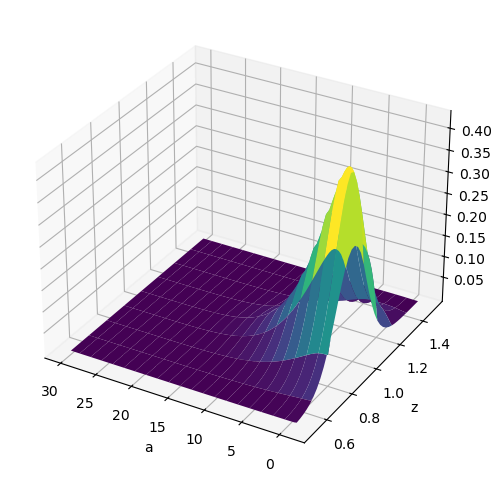

In [5]:
fig1 = plt.figure(figsize=(8, 6), dpi=100)
ax = fig1.add_subplot(111, projection='3d')
A_plot,Z_plot = np.meshgrid(a, z)
ax.invert_xaxis()
surface = ax.plot_surface(A_plot, Z_plot, g.T, cmap='viridis', rstride=5, cstride=5, alpha=1, antialiased=True)
ax.set_xlabel('a')
ax.set_ylabel('z')